In [84]:
# 1 FILTER DATAFRAME USING THE SAME BOUNDING BOX YOU HAVE USED FOR QUERYING THE API
# 2 FETCH THE IMAGE IDS IN THE SAME BOUNDING BOX WITH MAPILLARY
# 3 MATCH THE IMAGE IDS WITH THE EDGE IDS:
#### - ADD EXTRA POINTS BETWEEN EVERY EDGE START AND END (edge points) 
#### - Construct A BALL TREE WITH THE EDGE POINTS (https://stackoverflow.com/questions/56862277/interpreting-sklearn-haversine-outputs-to-kilometers)
#### - Query the Ball tree using the simage points (for each image, find the closest point)
#### - Remove matches such that the distance is larger than 50 meters
#### - Build a dictionary image_id --> edge_id

In [85]:
import geopandas as gpd
import matplotlib.pylab as plt
from shapely.geometry import Polygon
import numpy as np
import itertools
from operator import itemgetter
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString
import requests as rq
import json
from sklearn.neighbors import BallTree
from dbfread import DBF

In [86]:
#Load shapefile

my_shapefile_path = "/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
my_shp = gpd.read_file(my_shapefile_path)
#print(my_shp)

In [87]:
#Access to Mapillary API

clienttoken = "MLY|6271859919532158|486bcdece7a665eb89a5803f2994b4c9"


#URL for getting only images within the chosen boundaries
url = f"https://graph.mapillary.com/images?access_token={clienttoken}&fields=id,computed_geometry&bbox=12.539467,55.660144,12.563714,55.675971"

response = rq.get(url)

rqcon = response.content

#Decode in order to get rid og bytestring 
deco = rqcon.decode()

result = json.loads(deco)
images = list(result.values())[0]

#Loop to get list of coordinates and ID's 
#Not all images has coordinates so the try/except only gets the ID's which has coordinates
coor = []
ID = []
for i in range(0,len(images)):
    try:
        coord = images[i]["computed_geometry"]["coordinates"]
        coor.append(coord)
        id = str(images[i]["id"])
        ID.append(id)
    except KeyError:
        continue
#print(coor[0][0])
#print(ID)
new_coor =[] 
for i in range(0,len(coor)):
    vupti = coor[i][0]




#Get coordinates as Shapely Points 
points = []

for i in range(0,len(coor)):
    point = Point(coor[i])
    points.append(point)

#print(points)

#Check if Id and points are the same length
#print(len(ID))
#print(len(points))


#Create geopandas dataframe from ID's and points
dataframepoints = {"ID": ID, "geometry": points}
df_points = gpd.GeoDataFrame(dataframepoints)
num_images = len(df_points)

print(df_points)


                    ID                   geometry
0     1244222213077086  POINT (12.54743 55.67326)
1     1376558909555915  POINT (12.55877 55.66531)
2     1376733259375980  POINT (12.54441 55.67346)
3     1450916735253965  POINT (12.54254 55.66388)
4     1473314156434056  POINT (12.54139 55.66187)
...                ...                        ...
1981  1411972499560654  POINT (12.54567 55.66995)
1982  1502525563509680  POINT (12.55841 55.66194)
1983  2423746001112127  POINT (12.55624 55.66279)
1984  3351411285096256  POINT (12.54405 55.67391)
1985  3469811449786905  POINT (12.54393 55.66696)

[1986 rows x 2 columns]


In [88]:
#Set boundaries
bound = Polygon([(12.539467, 55.660144), (12.539467, 55.675971),(12.563714, 55.675971), (12.563714, 55.660144)])

#Find the values from the shapefile that is within the boundaries
TF = my_shp.within(bound)


edges_within_bound_index = TF[TF].index

geo_tag = my_shp["geometry"][TF.values]


emp_list = []
for i in range(0,len(edges_within_bound_index)):
    segment_list = []
    for i in list(geo_tag.iloc[i].coords):
        segment_list.append(list(i))
    #if 2 < len(segment_list):
    #    continue
    emp_list.append(segment_list)



#Create dataframe 
data1 = {"ID": my_shp["edgeUID"][TF.values], "geometry": geo_tag}
df_lines = gpd.GeoDataFrame(data1)
print(df_lines)


#df_lines = gpd.GeoDataFrame(TF)



               ID                                           geometry
47      174472823  LINESTRING (12.54255 55.66452, 12.54272 55.66479)
188     174472925  LINESTRING (12.54329 55.66718, 12.54352 55.667...
515     174477311  LINESTRING (12.56242 55.67385, 12.56234 55.67394)
845     174474161  LINESTRING (12.54380 55.67105, 12.54376 55.67109)
849     174477032  LINESTRING (12.56357 55.67126, 12.56361 55.67128)
...           ...                                                ...
301660  174474898  LINESTRING (12.54812 55.66269, 12.54809 55.66274)
301676  174475046  LINESTRING (12.55384 55.66429, 12.55399 55.66431)
301682  174475045  LINESTRING (12.55396 55.66422, 12.55400 55.664...
301756  174475042  LINESTRING (12.55399 55.66431, 12.55398 55.664...
301808  174475039  LINESTRING (12.55413 55.66424, 12.55396 55.66422)

[2442 rows x 2 columns]


<Axes: >

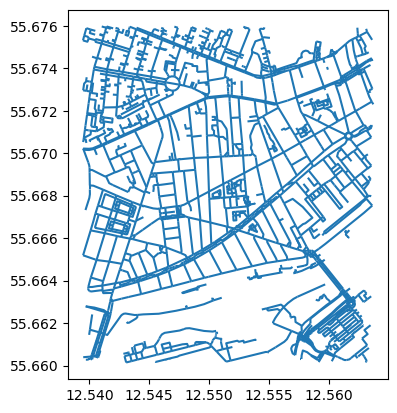

In [89]:

df_lines["geometry"].plot()

/tmp/ipykernel_226298/3281745053.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer


<Axes: >

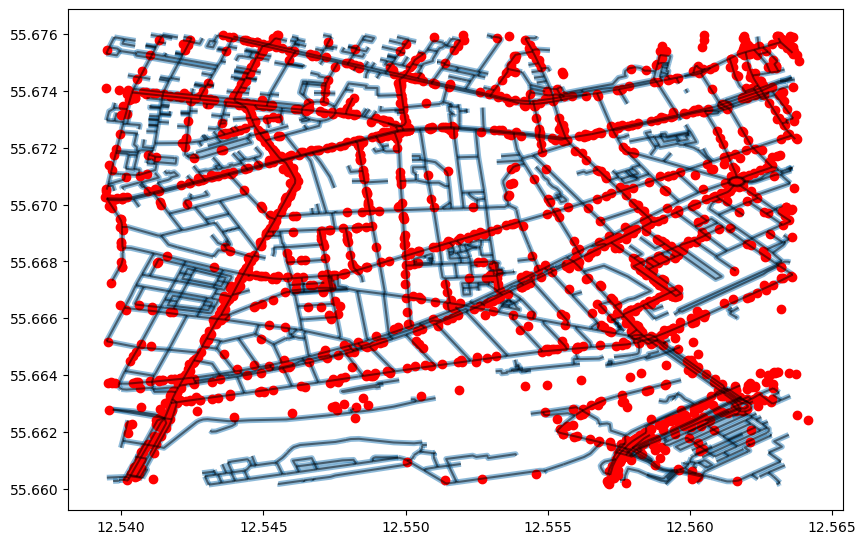

In [90]:
fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer
#df_lines["geometry"].plot(ax=ax,alpha=0.5)  #W/o buffer
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
df_points["geometry"].plot(ax=ax,color = "r")



## Non-assigned Pictures

/tmp/ipykernel_226298/898194467.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)
/tmp/ipykernel_226298/898194467.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)


249


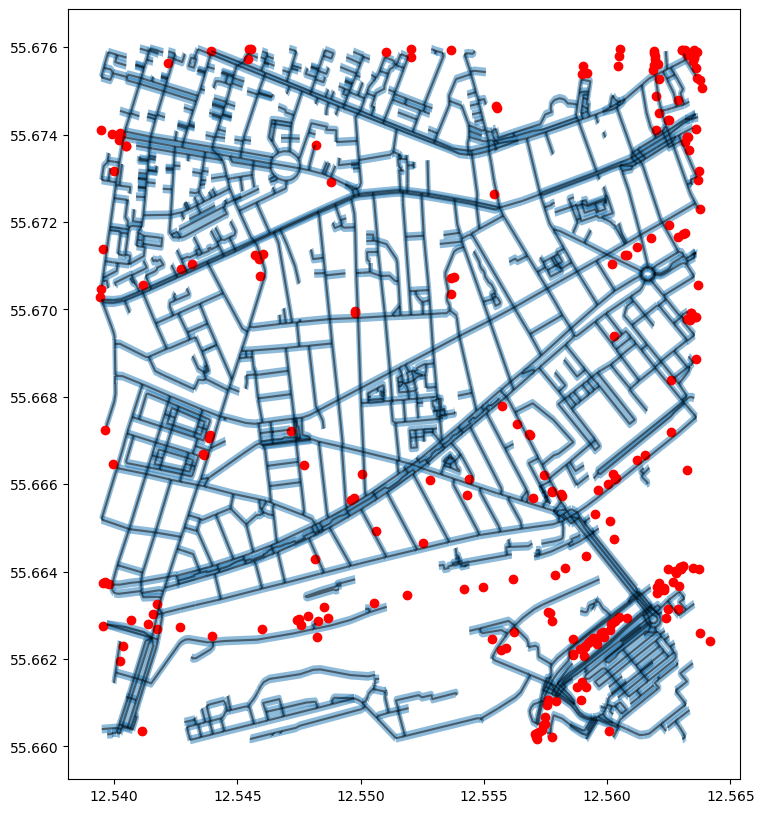

In [91]:
df_polygons = df_lines.copy()
df_polygons.crs = df_lines.crs
df_points.crs = df_lines.crs
df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)

pointInPoly = gpd.sjoin(df_points, df_polygons, how='left',predicate='within') 

fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
pointInPoly[pointInPoly['index_right'].isna()].plot(ax=ax,color = "r")

print(len(pointInPoly[pointInPoly['index_right'].isna()]))


In [92]:
pointInPoly

,ID_left,geometry,index_right,ID_right
0,1244222213077086,POINT (12.54743 55.67326),225780.0,174476221.0
1,1376558909555915,POINT (12.55877 55.66531),122652.0,174475729.0
1,1376558909555915,POINT (12.55877 55.66531),167964.0,174475728.0
1,1376558909555915,POINT (12.55877 55.66531),186331.0,174475737.0
1,1376558909555915,POINT (12.55877 55.66531),241949.0,174475702.0
...,...,...,...,...
1983,2423746001112127,POINT (12.55624 55.66279),106928.0,174475052.0
1983,2423746001112127,POINT (12.55624 55.66279),115668.0,174475051.0
1984,3351411285096256,POINT (12.54405 55.67391),39422.0,174474559.0
1984,3351411285096256,POINT (12.54405 55.67391),81030.0,174474558.0


<Axes: >

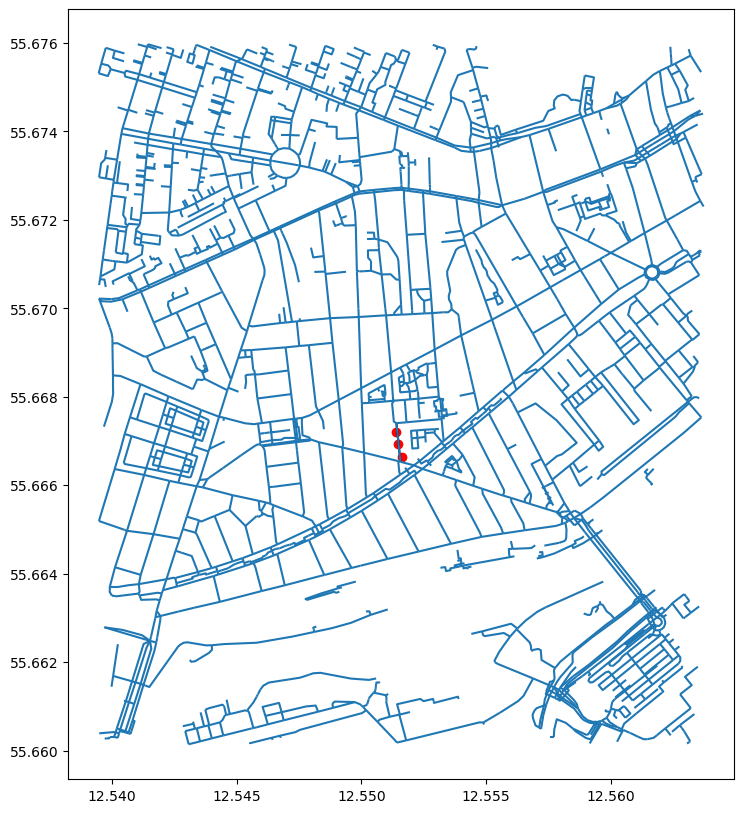

In [93]:
fig, ax = plt.subplots(figsize = (10,10))
test = pointInPoly[pointInPoly.ID_right==174475028].copy()
df_lines[df_lines.ID==174475028].plot(ax=ax, color = "k")
df_lines.plot(ax=ax)
test["geometry"].plot(color = "r",ax=ax)

(55.660144, 55.675971)

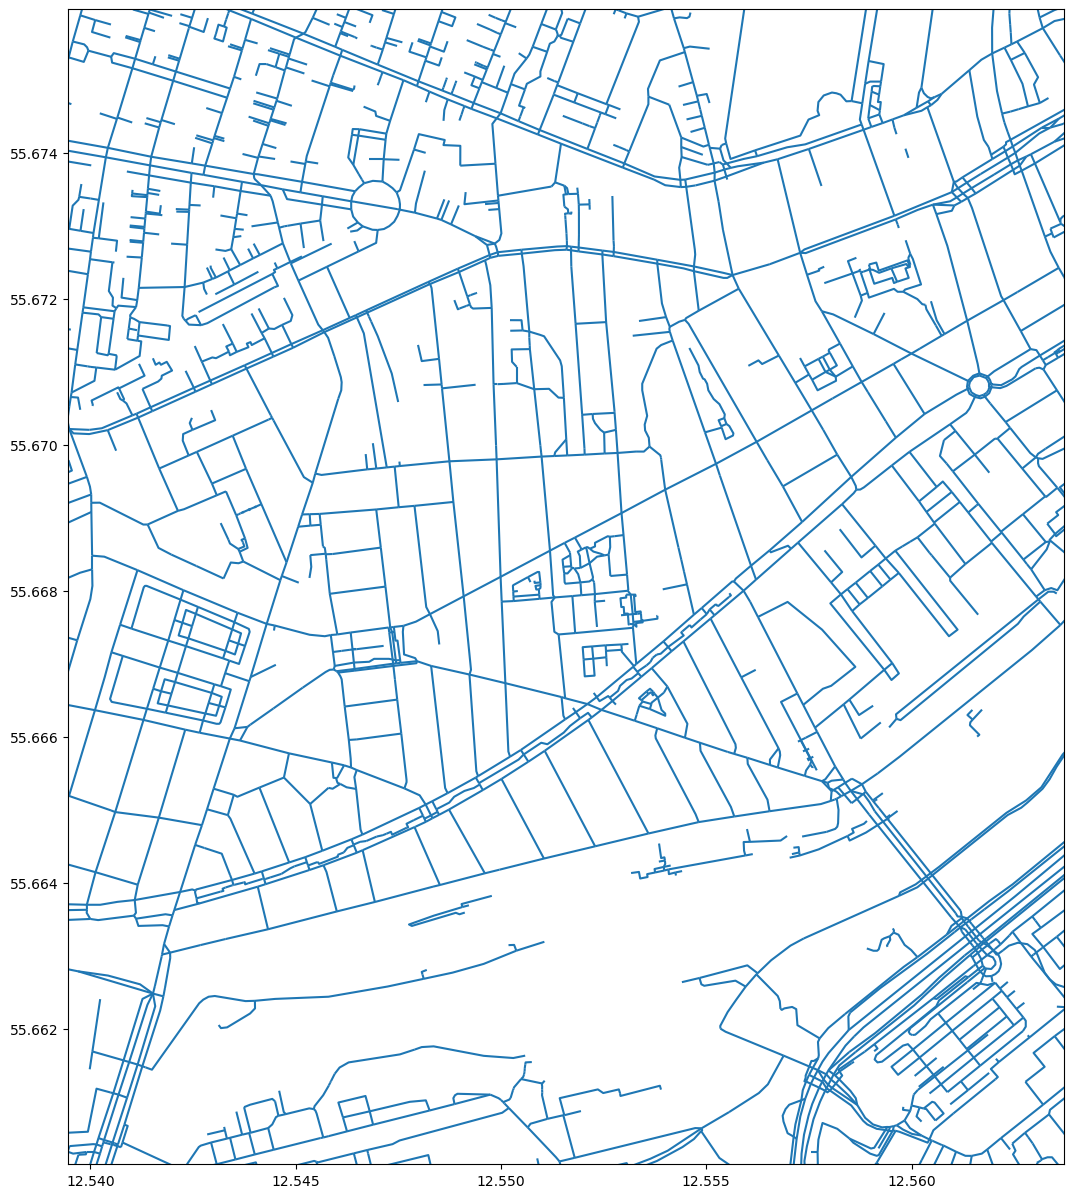

In [94]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
my_shp.plot(ax = ax)

ax.set_xlim(12.539467, 12.563714)
ax.set_ylim(55.660144, 55.675971)

In [95]:
#Shapefile gives edgeUID, osmId and geometry 
shp = "/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
strava_shape = gpd.read_file(shp)
#print(strava_shape)

#csv-file gives edge_uid, actitivity type, date, total_trip_count etc. 
strava_csv = pd.read_csv("/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.csv")
#print(strava_csv)

#dbf-file gives edgeUID and osmId 
dbf = DBF('/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.dbf')
frame = pd.DataFrame(iter(dbf))
#print(frame)

#textfile ???
file1 = open("/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.txt","r")
#print(file1)

In [96]:
print(strava_csv['activity_type'].unique())

['Run,Walk,Hike']


In [97]:
print(strava_csv['month'].unique())

['2022-02' '2022-03' '2022-04' '2022-06' '2022-01' '2022-08' '2022-05'
 '2022-12' '2022-07' '2022-11' '2022-10' '2022-09']


In [98]:
csv_df = {"ID": strava_csv["edge_uid"], "Activity": strava_csv["total_trip_count"]}
# "Month": strava_csv["month"]
csv_df = pd.DataFrame(data=csv_df)
csv_df = csv_df.dropna(subset=["ID"])
csv_df["Summed activity"] = csv_df.groupby("ID")["Activity"].transform("mean")


collapsed_df = csv_df.drop_duplicates(subset=["ID"], keep="first")
filtered_df = collapsed_df[collapsed_df["ID"].isin(df_lines["ID"])]

activity_df = pd.DataFrame({"ID": filtered_df["ID"], "Activity": filtered_df["Summed activity"]})

list_ID_ac = activity_df["ID"].tolist()
list_ID_line = df_lines["ID"].tolist()
print((len(list_ID_ac),len(list_ID_line)))


def count_occurrence(lst):
    count = {}
    for item in lst:
        if item in count:
            count[item] += 1
        else:
            count[item] = 1
    return count

unique_occurrences_month = count_occurrence(list(strava_csv["month"]))
print(unique_occurrences_month)

print(activity_df)


(1901, 2442)
{'2022-02': 139008, '2022-03': 143180, '2022-04': 141045, '2022-06': 138422, '2022-01': 147576, '2022-08': 144742, '2022-05': 141423, '2022-12': 130012, '2022-07': 137169, '2022-11': 132616, '2022-10': 136460, '2022-09': 137626}
                ID    Activity
3552     174476152  105.000000
4284     174476138   60.416667
5205     174472857  990.416667
5217     174475361  932.500000
6086     174474204  487.916667
...            ...         ...
1662088  174475728  990.833333
1662100  174476604  837.500000
1664757  174474907   47.083333
1665491  174474571  389.166667
1665515  174476242  244.583333

[1901 rows x 2 columns]


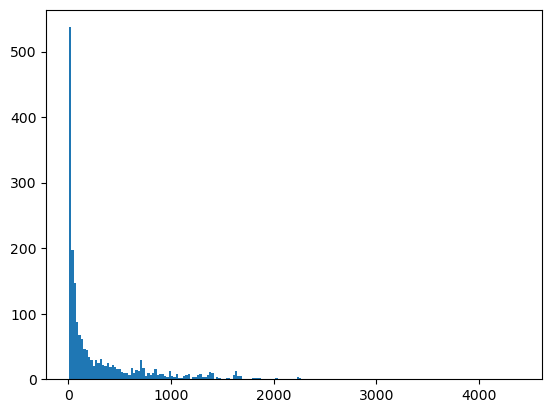

[]


In [99]:
x = activity_df["Activity"]
plt.hist(x,bins=int(len(activity_df["Activity"])/10))
plt.show()

index = []

for i in range(0,len(list(activity_df["Activity"]))):
    if list(activity_df["Activity"])[i] == 0:
        index.append(list(activity_df["Activity"])[i])
    
print(index)


In [100]:
merged_df = pd.merge(pointInPoly, activity_df, left_on="ID_right", right_on="ID")
merged_df

,ID_left,geometry,index_right,ID_right,ID,Activity
0,1244222213077086,POINT (12.54743 55.67326),225780.0,174476221.0,174476221,2094.166667
1,1242073322892468,POINT (12.54745 55.67317),225780.0,174476221.0,174476221,2094.166667
2,1261653407922969,POINT (12.54650 55.67330),225780.0,174476221.0,174476221,2094.166667
3,2595625920740938,POINT (12.54662 55.67339),225780.0,174476221.0,174476221,2094.166667
4,3064875427157847,POINT (12.54645 55.67334),225780.0,174476221.0,174476221,2094.166667
...,...,...,...,...,...,...
2542,2279014902258166,POINT (12.55672 55.67391),59531.0,174476636.0,174476636,825.000000
2543,2570553693248633,POINT (12.55445 55.66819),293658.0,174476112.0,174476112,167.500000
2544,1671999902983901,POINT (12.54485 55.67522),165334.0,174474614.0,174474614,454.583333
2545,1335161657007959,POINT (12.56071 55.67478),47316.0,174477337.0,174477337,292.916667


In [101]:
isnull = merged_df.index[merged_df["Activity"].isnull()].tolist()

isnull

[]

In [102]:
'''
result = merged_df.drop_duplicates(['ID_left'],keep='first')
result
reset = result.reset_index()
reset.pop("index")
reset
#dataframe2 = reset.rename(columns = {"ID_left": "Image ID","geometry": "Image coordinate","index_right": "Segment index","ID_right": "Segment ID", "ID": "Segment ID","Activity": "Activity"}, inplace=True)
#print(dataframe2)
'''

'\nresult = merged_df.drop_duplicates([\'ID_left\'],keep=\'first\')\nresult\nreset = result.reset_index()\nreset.pop("index")\nreset\n#dataframe2 = reset.rename(columns = {"ID_left": "Image ID","geometry": "Image coordinate","index_right": "Segment index","ID_right": "Segment ID", "ID": "Segment ID","Activity": "Activity"}, inplace=True)\n#print(dataframe2)\n'

In [103]:
list_image_id = pointInPoly["ID_left"].tolist()
list_image_id_new = list_image_id[0:1000]
list_image_id_new = [eval(i) for i in list_image_id_new]
list_image_id = [eval(i) for i in list_image_id]
#print(list_image_id_new)

clienttoken = "MLY|6271859919532158|486bcdece7a665eb89a5803f2994b4c9"
#URL for getting only images within the chosen boundaries


ID_image = []
detection = []

for i in range(0,len(list_image_id_new)):
    url = f"https://graph.mapillary.com/{list_image_id_new[i]}/detections?access_token={clienttoken}&fields=image,value"
    response = rq.get(url)
    rqcon = response.content
    #Decode in order to get rid of bytestring 
    deco = rqcon.decode()
    result = json.loads(deco)
    images = list(result.values())[0]
    #print(len(images))
    #print(images)
    for i in range(0,len(images)):
        try:
            val = str(images[i]["value"])
            detection.append(val)
            ID = str(images[i]["image"]["id"])
            ID_image.append(ID)
        except KeyError:
            continue
            
#list of objects to remove 
vd = ["void--dynamic","void--static","void--unlabeled"]

indices_to_remove = [i for i, string in enumerate(detection) if string in vd]
new_string_list = []
new_index_list = []
for i in range(len(detection)):
    if i not in indices_to_remove:
        new_string_list.append(detection[i])
        new_index_list.append(ID_image[i])
    



#print((len(new_index_list),len(new_string_list)))
dataframevalue = {"ID": new_index_list, "Detection": new_string_list}
df_imagess = gpd.GeoDataFrame(dataframevalue)
#print(df_imagess)
            
dict_image = df_imagess.groupby('ID')['Detection'].agg(list).to_dict()
#print(dict_image)
#print(dict_image)
dict_image2 = list(dict_image.values())
#print(dict_image2)
dict_image3 =sum(dict_image2, [])
#print(dict_image3)

def count_occurrence(lst):
    count = {}
    for item in lst:
        if item in count:
            count[item] += 1
        else:
            count[item] = 1
    return count

unique_occurrences = count_occurrence(dict_image3)

detections_per_image = []
dict_image_ids = []
image_ids = list(dict_image.keys())
for id in image_ids:
    dict_image_ids.append({'image_id': '{}'.format(id)})
    detections = count_occurrence(dict_image[id])
    detections_per_image.append(detections)
df_detections = pd.DataFrame.from_dict(detections_per_image)
df_image_ids = pd.DataFrame.from_dict(dict_image_ids)

#print(pd.DataFrame.from_dict(detections_per_image))
print(pd.DataFrame.from_dict(dict_image_ids))
print(pd.concat([df_image_ids,df_detections], axis = 1))

    

sorted_unique_occurrences = sorted(unique_occurrences.items(), key=lambda x:x[1])
#print(sorted_unique_occurrences)

             image_id
0    1229508987463386
1    1230883217849337
2    1232281927693957
3    1232805993989325
4    1233198214250098
..                ...
529  5777882162298742
530  5900428473343801
531  6094522170573362
532  6149794991707798
533  8751111771627232

[534 rows x 1 columns]
             image_id  object--street-light  object--trash-can  \
0    1229508987463386                   2.0                2.0   
1    1230883217849337                   NaN                NaN   
2    1232281927693957                   1.0                1.0   
3    1232805993989325                  12.0                NaN   
4    1233198214250098                   4.0                NaN   
..                ...                   ...                ...   
529  5777882162298742                   NaN                NaN   
530  5900428473343801                  12.0                NaN   
531  6094522170573362                   1.0                1.0   
532  6149794991707798                   1.0         

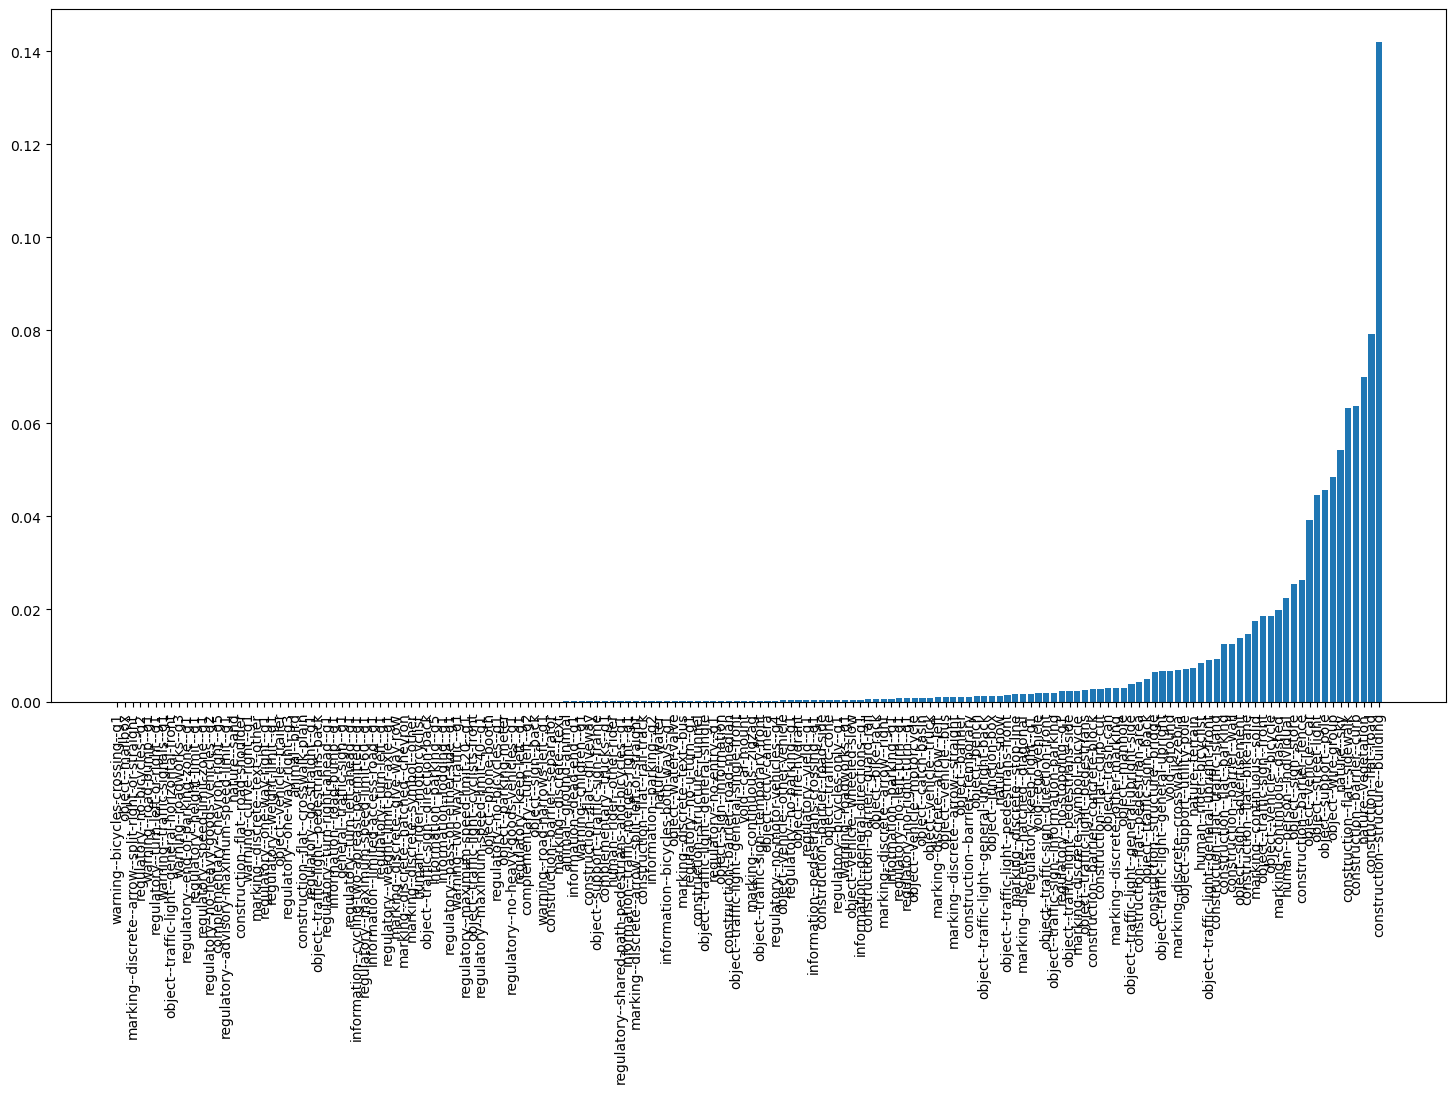

In [104]:

x_bar, y_bar = zip(*sorted_unique_occurrences)
y_bar = [x/sum(y_bar) for x in y_bar]
plt.figure(figsize=(18,9))
plt.bar(x_bar, y_bar)
plt.xticks(rotation = 90)
plt.show()

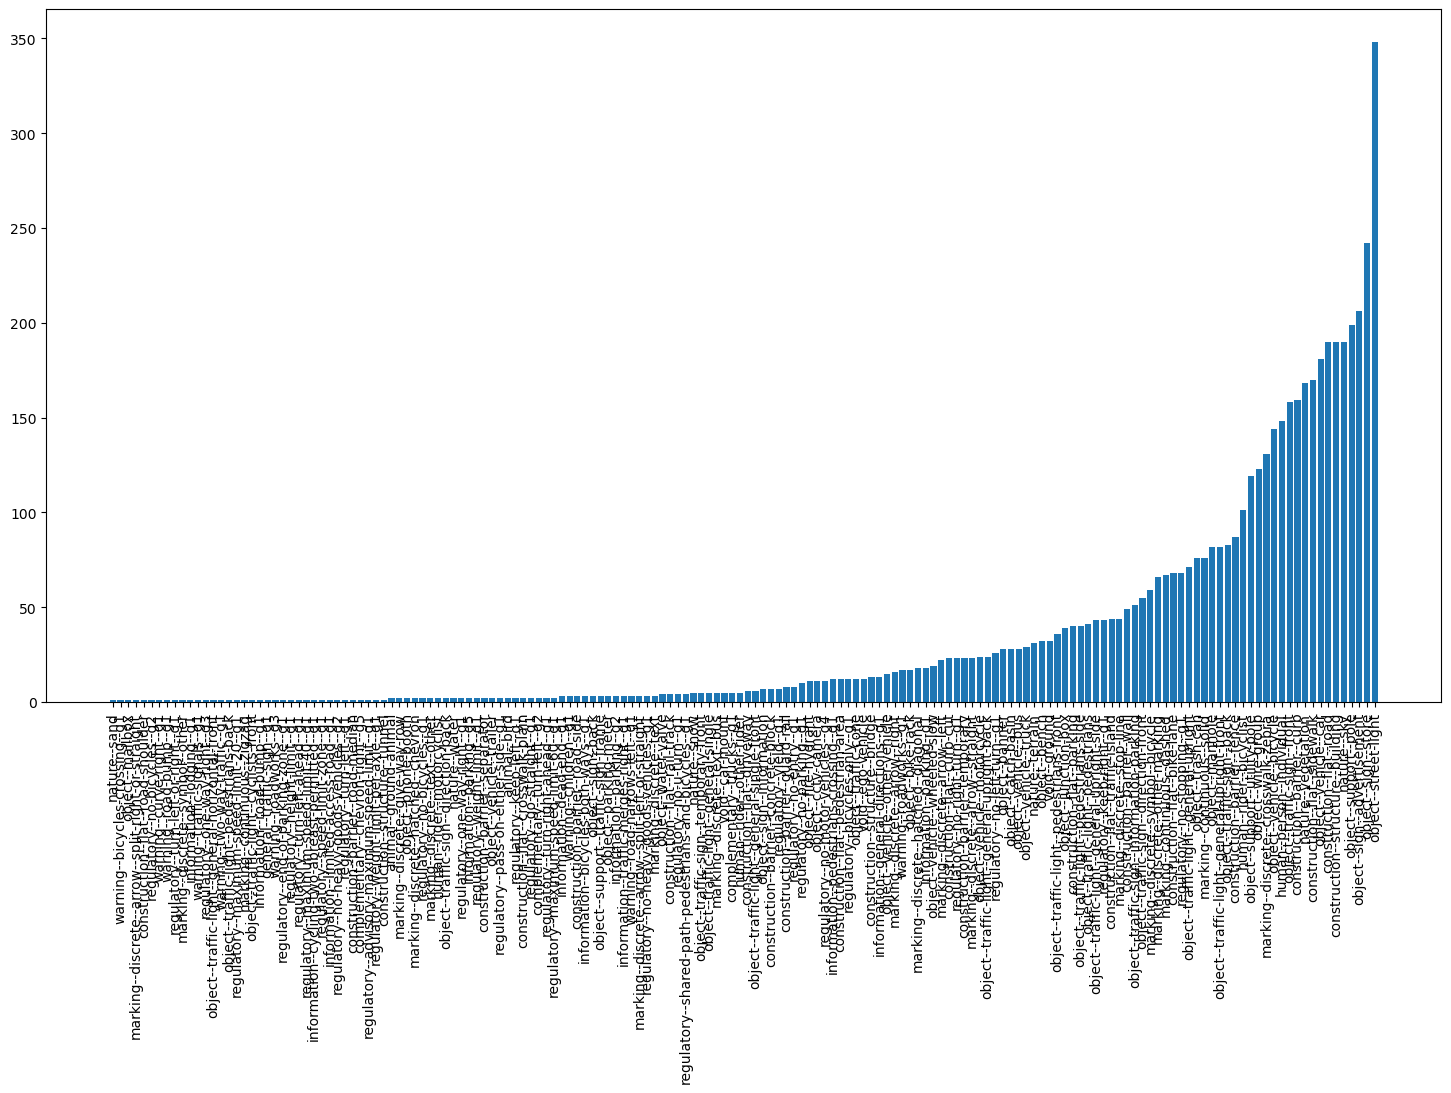

In [105]:
encounters = []
for keys in dict_image.keys():
    dab = count_occurrence(dict_image[keys])
    objects_found = list(dab.keys()) 
    encounters.append(objects_found)
encounters_tolist =  sum(encounters, [])
encounters_todict = count_occurrence(encounters_tolist)
sorted_unique_picture_encounters = sorted(encounters_todict.items(), key=lambda x:x[1])

x_bar, y_bar = zip(*sorted_unique_picture_encounters)
y_bar = [x for x in y_bar]
plt.figure(figsize=(18,9))
plt.bar(x_bar, y_bar)
plt.xticks(rotation = 90)
plt.show()

# Creating dataframe with data for tree model

In [106]:
#Loop over detections and create dictionaries, which can be manipulated for the creation of pd.dataframes

detections_per_image = []
dict_image_ids = []
image_ids = list(dict_image.keys())
for id in image_ids:
    dict_image_ids.append({'image_id': '{}'.format(id)})
    detections = count_occurrence(dict_image[id])
    detections_per_image.append(detections)

df_detections = pd.DataFrame.from_dict(detections_per_image)
df_image_ids = pd.DataFrame.from_dict(dict_image_ids)

#Concatenate the two dataframes containing detections per image and the image ID
image_detections = pd.concat([df_image_ids,df_detections], axis = 1)

#Assigning image ID's to edge ID's through pandas join functions
nonna_pointInPoly = pointInPoly.dropna()
df_image_edge = nonna_pointInPoly[["ID_left","ID_right"]]
df_image_edge = df_image_edge.rename(columns={'ID_left':'image_id', 'ID_right':'edge_id'})
merged_df = pd.merge(image_detections,df_image_edge, on = 'image_id')

#Lastly joining the activity from strava for the creation of the full dataset: |image_ids|detections|edge_id|#people|
df_activity = activity_df.rename(columns={'ID':'edge_id'})
data =  pd.merge(merged_df, df_activity, on='edge_id')

#Move edge_id column to location 0
edge_id_column = data.pop('edge_id')
data.insert(0, "edge_id", edge_id_column)
#Replace NaN with 0
data = data.fillna(0)

#Dataframe now looks like: |edge_id|image_ids|detections|#people|
print(data)

         edge_id          image_id  object--street-light  object--trash-can  \
0    174474564.0  1229508987463386                   2.0                2.0   
1    174474564.0  1353260028380133                   2.0                0.0   
2    174474564.0  1998917563580031                   2.0                0.0   
3    174474564.0  2263462060470281                   4.0                0.0   
4    174474564.0  2898434417151935                   3.0                0.0   
..           ...               ...                   ...                ...   
736  174476797.0  4563353613781376                   1.0                1.0   
737  174472967.0  5427458374030639                   0.0                0.0   
738  174475351.0  5533781886679902                   6.0                0.0   
739  174475416.0  5726119597472125                  18.0                0.0   
740  174472960.0  6149794991707798                   1.0                0.0   

     object--support--utility-pole  construction--f

## Pop columns of detections that dont appear in atleast 5% of the pictures

In [107]:
#Identify detections that are over 5%
df_unique_detections=pd.DataFrame(list(zip(x_bar,y_bar)),columns=['detection','occurence'])
df_unique_detections = df_unique_detections[df_unique_detections['occurence'] >= 0.02]
detections_of_interest = df_unique_detections['detection'].to_list()
#Now we have a list with the detections that we are interested in. We insert the coloumn names for edge ID, image ID 
#and activity to get that from our data dataframe
detections_of_interest.insert(0, 'edge_id')
detections_of_interest.insert(1, 'image_id')
detections_of_interest.append('Activity')
#Thus getting the desired columns for our data
data = data[detections_of_interest]

In [108]:
averaged_data = data
averaged_data = averaged_data.loc[:, averaged_data.columns != 'image_id']
averaged_data = averaged_data.loc[:, averaged_data.columns != 'Activity']
averaged_data=averaged_data.groupby('edge_id').mean().reset_index()
print(averaged_data)

         edge_id  nature--sand  warning--bicycles-crossing--g1  \
0    174472494.0           0.0                             0.0   
1    174472495.0           0.0                             0.0   
2    174472496.0           0.0                             0.0   
3    174472498.0           0.0                             0.0   
4    174472503.0           0.0                             0.0   
..           ...           ...                             ...   
448  174477347.0           0.0                             0.0   
449  174477348.0           0.0                             0.0   
450  174477350.0           0.0                             0.0   
451  174477351.0           0.0                             0.0   
452  174477478.0           0.0                             0.0   

     object--mailbox  marking--discrete--arrow--split-right-or-straight  \
0                0.0                                                0.0   
1                0.0                                     

In [109]:
print(max(data["Activity"]))
print(min(data["Activity"]))
print(np.mean(data["Activity"]))
print(data.Activity.quantile([0.25,0.5,0.75]))

4398.75
5.0
566.9389662481767
0.25    122.083333
0.50    409.166667
0.75    826.250000
Name: Activity, dtype: float64


In [110]:
low = []
medium = []
high = []

for i in range(0,len(data["Activity"])):
    if data["Activity"][i] < np.percentile(data.Activity, 33):
        low.append(data["Activity"][i])
    if np.percentile(data.Activity, 33) <= data["Activity"][i] < np.percentile(data.Activity, 66):
        medium.append(data["Activity"][i])
    if np.percentile(data.Activity, 66) <= data["Activity"][i]:
        high.append(data["Activity"][i])
        
print((low,medium,high))
print(len(low+medium+high))
print(len(data["Activity"]))


([141.25, 141.25, 141.25, 141.25, 141.25, 5.0, 104.16666666666667, 30.416666666666668, 76.25, 51.25, 51.25, 51.25, 161.25, 54.166666666666664, 15.416666666666666, 62.5, 62.5, 57.5, 57.5, 45.416666666666664, 5.0, 5.0, 10.0, 10.0, 7.5, 52.916666666666664, 84.16666666666667, 84.16666666666667, 84.16666666666667, 84.16666666666667, 60.833333333333336, 60.833333333333336, 60.833333333333336, 87.5, 87.5, 126.66666666666667, 126.66666666666667, 126.66666666666667, 126.66666666666667, 126.66666666666667, 17.083333333333332, 17.083333333333332, 17.083333333333332, 17.083333333333332, 17.083333333333332, 17.083333333333332, 17.083333333333332, 142.91666666666666, 43.333333333333336, 133.33333333333334, 122.08333333333333, 165.0, 165.0, 61.25, 161.66666666666666, 125.0, 11.25, 29.166666666666668, 30.833333333333332, 30.833333333333332, 30.833333333333332, 57.916666666666664, 163.33333333333334, 163.33333333333334, 37.5, 37.5, 5.0, 5.0, 7.5, 72.08333333333333, 72.08333333333333, 109.16666666666667

In [111]:
for i in range(0, len(data["Activity"])):
    if data["Activity"][i] in low: 
        data.at[i, "Activity"] = 0
    if data["Activity"][i] in medium: 
        data.at[i, "Activity"] = 1
    if data["Activity"][i] in high: 
        data.at[i, "Activity"] = 2
        
print(data)

print((len(low),len(medium),len(high)))



         edge_id          image_id  nature--sand  \
0    174474564.0  1229508987463386           0.0   
1    174474564.0  1353260028380133           0.0   
2    174474564.0  1998917563580031           0.0   
3    174474564.0  2263462060470281           0.0   
4    174474564.0  2898434417151935           0.0   
..           ...               ...           ...   
736  174476797.0  4563353613781376           0.0   
737  174472967.0  5427458374030639           0.0   
738  174475351.0  5533781886679902           0.0   
739  174475416.0  5726119597472125           0.0   
740  174472960.0  6149794991707798           0.0   

     warning--bicycles-crossing--g1  object--mailbox  \
0                               0.0              0.0   
1                               0.0              0.0   
2                               0.0              0.0   
3                               0.0              0.0   
4                               0.0              0.0   
..                              ...    

Cross-validation accuracy scores: [0.3466666666666667, 0.33783783783783783, 0.33783783783783783, 0.3783783783783784, 0.35135135135135137, 0.47297297297297297, 0.527027027027027, 0.32432432432432434, 0.33783783783783783, 0.3783783783783784]
Best accuracy: 0.527027027027027
Mean score: 0.37926126126126125
Best class: 0
Worst class: 1


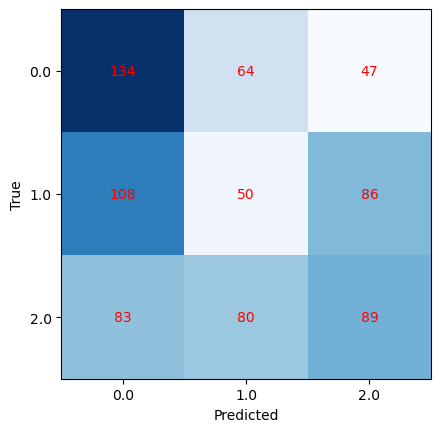

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Assuming your data is in a dataframe called `data`, with features in X and target in y
X = data.drop(columns=["Activity","edge_id","image_id"])  # Features
y = data["Activity"]  # Target

# Define the random forest classifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=5)

# Define the k-fold cross-validation object
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform k-fold cross-validation and get the predicted values for each fold
y_pred = cross_val_predict(rfc, X, y, cv=kfold)

# Calculate the accuracy score for each fold
accuracy_scores = []
for train_idx, test_idx in kfold.split(X):
    rfc.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_test_pred = rfc.predict(X.iloc[test_idx])
    accuracy_scores.append(accuracy_score(y.iloc[test_idx], y_test_pred))

# Calculate the confusion matrix across all folds
conf_matrix = confusion_matrix(y, y_pred)

# Get the class that the model is best at predicting
best_class = conf_matrix.diagonal().argmax()

# Get the class that the model misclassifies the most
worst_class = (conf_matrix.sum(axis=1) - conf_matrix.diagonal()).argmax()

# Print the results
print("Cross-validation accuracy scores:", accuracy_scores)
print("Best accuracy:", max(accuracy_scores))
print("Mean score:", sum(accuracy_scores) / len(accuracy_scores))
print("Best class:", best_class)
print("Worst class:", worst_class)

# Plot the confusion matrix
classes = np.unique(y)
fig, ax = plt.subplots()
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, conf_matrix[i, j],
                ha="center", va="center", color="red")
plt.show()
